In [1]:
!pip install gender-guesser
!pip install nameparser
!pip install text2emotion

In [2]:
import csv
import json
import re
import pandas as pd
import numpy as np
import text2emotion as te

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/prakshal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/prakshal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/prakshal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
import gender_guesser.detector as gender
from nameparser import HumanName
from dateutil import parser

In [4]:
d = gender.Detector(case_sensitive=False)

In [21]:
def read_csv(filename):
    with open(filename) as csvfile:
        reader = csv.DictReader(csvfile, delimiter=',')
        return list(reader)

In [22]:
def sanatize_keywords_old_dataset(test_str):
    COMMA_MATCHER = re.compile(r",(?=(?:[^\"']*[\"'][^\"']*[\"'])*[^\"']*$)")
    split_result = COMMA_MATCHER.split(test_str)
    
    # Convert key-value String to dictionary
    # Using map() + split() + loop
    res = []
    for sub in split_result:
        if ':' in sub:
            res.append(map(str.strip, sub.split(':', 1)))
    res = dict(res)
    res = {key.replace('"', ''):val.replace('"', '') for key, val in res.items()}
    return res

def sanatize_keywords_new_dataset(test_str):
    key_list = eval(test_str)
    return dict(key_list)

In [23]:
get_new_dataset_contents = read_csv('latest_large_obituary.csv')
get_old_dataset_contents = read_csv('Meta.csv')

In [24]:
distributions_years = {}
for person in get_old_dataset_contents:
    keywords = sanatize_keywords_old_dataset(person["keywords"])
    if("persons" not in keywords):
        continue
    first_name = HumanName(keywords["persons"].strip('"')).first
    # Get the gender of the person
    gender = d.get_gender(first_name)
    
    
    # Get the year when obituary published
    year = parser.parse(person["pub_date"].split("+")[0]).year
    if(year not in distributions_years):
        distributions_years[year] = {"male": 0, "female": 0, "unknown": 0, "andy": 0, "mostly_male": 0, "mostly_female": 0}
    distributions_years[year][gender] += 1

for person in get_new_dataset_contents:
    keywords = sanatize_keywords_new_dataset(person["keywords"])
    if("persons" not in keywords):
        continue
    first_name = HumanName(keywords["persons"].strip('"')).first
    # Get the gender of the person
    gender = d.get_gender(first_name)
    
    
    # Get the year when obituary published
    year = parser.parse(person["pub_date"].split("+")[0]).year
    if(year not in distributions_years):
        distributions_years[year] = {"male": 0, "female": 0, "unknown": 0, "andy": 0, "mostly_male": 0, "mostly_female": 0}
    distributions_years[year][gender] += 1

In [25]:
dataframe_data = {key : list(value.values()) for key, value in distributions_years.items()}

In [26]:
plot_data = {'male': [], 'female': [], 'unknown': [], 'andy': [], 'mostly_male': [], 'mostly_female': []}
for key, value in distributions_years.items():
    for gender, count in value.items():
        plot_data[gender].append(count)

x_axis = distributions_years.keys()

In [27]:
df = pd.DataFrame(data=plot_data, dtype=np.int8)

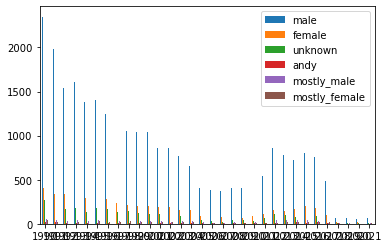

In [28]:
df = pd.DataFrame(plot_data, index=x_axis)
ax = df.plot.bar(rot=0)

In [29]:
df = df.assign(prop_male = (df.male)/(df.male+df.female))

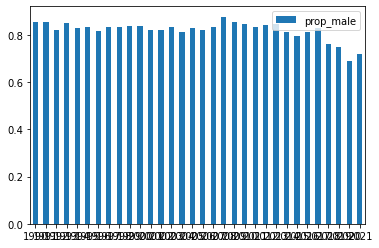

In [30]:
ax = df[['prop_male']].plot.bar(rot=0)

In [31]:
text = "This is so exciting. We are going to NYC!"
te.get_emotion(text)

{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 0.5, 'Fear': 0.5}

In [32]:
df = df.assign(prop_female = (df.female+df.mostly_female)/(df.male+df.female+df.unknown +df.mostly_male))

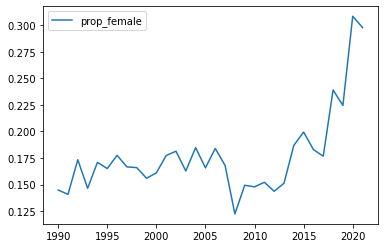

In [33]:
ax = df[['prop_female']].plot.line(rot=0)